## Executing the ARC challenges with Claude3.5

First download the challenges from:
- https://github.com/fchollet/ARC-AGI

This work uses the training set.
- https://github.com/fchollet/ARC-AGI/tree/master/data/training

The Anthropic API is used for Claude3.5, all 400 challenges can be completed for < $10
An api key is required.

In [1]:
# load challenge data from the file
import os

# set working directory
os.chdir("/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/MechInterp")
cwd = os.getcwd()
print(cwd)

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(usecwd=True))
ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')

/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/MechInterp


### Functions to convert the challenges into text for a prompt

Same as used for Gemma2

In [93]:
import numpy as np
import json
import pprint
from typing import List, Dict, Any

# Get all challenges in folder
def get_json_files(folder_path):
    json_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            json_files.append(filename)
    return json_files

# convert the training data for an individual challenge to a prompt
def get_train(filename: str):
    result = []
    with open('/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/' + filename, 'r') as file:
        dataset = json.load(file)

    train_len = len(dataset['train'])

    for pair in range(train_len):
        array_input  = np.array(dataset['train'][pair]['input'])
        array_output = np.array(dataset['train'][pair]['output'])

        #result.append("=============") if pair > 0 else None
        result.append(f"TRAIN Pair {pair}")
        result.append(f"INPUT. Shape={array_input.shape}")
        result.append(pprint.pformat(array_input))
        result.append(f"OUTPUT. Shape={array_output.shape}")
        result.append(pprint.pformat(array_output))

    test_actual = np.array(dataset['test'][0]['input'])
    #result.append("=============")
    result.append(f"TEST Pair 0")
    result.append(f"INPUT. Shape={test_actual.shape}")
    result.append(pprint.pformat(test_actual))
    result.append('OUTPUT. ')

    return '\n'.join(result)

# convert the test data for an individual challenge to a prompt
def get_test_outcome(filename: str):
    result = []
    with open('/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/' + filename, 'r') as file:
        dataset = json.load(file)

    test_actual = np.array(dataset['test'][0]['output'])
    # result.append("=============")
    # result.append(f"TARGET OUTPUT")
    result.append(f"OUTPUT. Shape={test_actual.shape}")
    result.append(pprint.pformat(test_actual))
 
    return test_actual, '\n'.join(result)

In [ ]:
folder_path = '/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/'
all_files      = get_json_files(folder_path)

print(f"All challenges: {len(all_files)}")


### Prompts, Long and Short

Same as for Gemma2

In [97]:
instructions_long = """# PROJECT INSTRUCTIONS

The training data consists of pairs of input and output grids, presented as numpy arrays of varying shapes.
Your task is to discover the single mapping which converts each input grid to its corresponding output grid and apply that to the test input, arriving at a test output.

## 1. OBSERVE AND HYPOTHESISE THE MAPPING LOGIC FOR ALL TRAINING PAIRS

When building your hypotheses on the mappings, be aware of the following common transformations:

    Grid Expansion and Repetition (Tiling):
    - Simply expand the grid and repeat (tile) the input grid into the output grid
    Symmetry and Mirroring (flipping):
    - Horizontally or vertically
    Propagation of patterns:
    - Identify non-zero clusters or shapes in the input grid and propagating them in the output. Proceeding horizontally, vertically or diagonally.
    Mathematical Operations:
    - Incrementing values, taking modulo, or performing addition.
    Color/Value Substitution:
    - Values in the input grid replaced with different values in the output grid, often changing all instances of one number to another
    Shape Detection and Transformation:
    - Identifying geometric shapes in the input grid and applying transformations such as rotation, scaling, flipping, translation and/or overlapping.
    Grid Segmentation:
    - Divide the input grid into sections and apply transformations to each section.
    Boundary Detection and Fill:
    - Identify the boundaries of shapes or patterns and fill them with specific values. This sometimes involved propagating values from the edges inward.
    Connectivity-based Transformations:
    - Using connected component analysis to identify and transform groups of connected cells.
    Rule-based Transformations:
    - Applying specific rules based on the arrangement of values in the input grid. These rules often considered the neighboring cells of each position.
    Coordinate-based Transformations:
    - Using the coordinates of cells to determine how they should be transformed or moved in the output grid.
    When the pattern is more complex than originally assumed:
    - Review all training pairs again and try to describe the transformation in plain language

Use these patterns to guide your own hypotheses on the training data.

## 2. PREDICT THE OUTPUT GRID FOR THE TEST INPUT GRID

Having considered the data...
FIRST score your confidence that you understand the mapping pattern, 0-5 where 0 is no confidence and 5 is highly confident. 
This score must be the FIRST output you give, no preamble, no prefix, no punctuation, just a single digit score.
THEN Present your predicted output in np.array format

## 3. THE DATA
"""

In [98]:
instructions_short = """Below are pairs of matrices. 
There is a mapping which operates on each input to give the output, only one mapping applies to all matrices. 
Review the matrices to learn that mapping and then estimate the missing output for the final input matrix.

FIRST score your confidence that you understand the mapping pattern, 0-5 where 0 is zero is no confidence and 5 is highly confident. 
This score must be the FIRST output you give, no preamble, no prefix, no punctuation, just a single digit score.
THEN Present your predicted output in np.array format
"""

confidence_measures = ['0','1','2','3', '4', '5']

### Helper Functions

a) To extract predicted matrix from the LLM's response. 
- On larger models we may demand a json response (aka 'function calling' or 'structured response') but this is not available for Gemma2.

b) Get the first token, which is the model's confidence score

c) Calculate similarity of the prediction with the target

In [99]:
import re
import ast

def get_first_token(text):
    match = re.match(r'(\w+|\d+)', text)
    first = False
    if match:
        first = match.group(1).lower()
    return first

def extract_and_convert_matrix(output):
    # Extract matrix string
    matrix_str = re.findall(r'\[(?:\[(?:\d+,?\s*)+\],?\s*)+\]', output)

    if not matrix_str or len(matrix_str[-1]) <= 2:
        return np.array([[0]])  # Return a default matrix if no valid matrix is found

    # Get the final instance of matrix in the text
    matrix_str = matrix_str[-1]
    # Replace newlines with commas when not prefixed with commas
    matrix_str = re.sub(r'\]\s*\n\s*\[', '], [', matrix_str)
    # Remove any remaining whitespace
    matrix_str = re.sub(r'\s', '', matrix_str)

    try:
        # Use ast.literal_eval for safe evaluation
        matrix_list = ast.literal_eval(matrix_str)

        # Check if the matrix is regular (all rows have the same length)
        if all(len(row) == len(matrix_list[0]) for row in matrix_list):
            return np.array(matrix_list)
        else:
            # If irregular, pad shorter rows with zeros
            max_length = max(len(row) for row in matrix_list)
            padded_matrix = [row + [0] * (max_length - len(row)) for row in matrix_list]
            return np.array(padded_matrix)

    except Exception as e:
        print(f"Error converting matrix: {e}")
        print(f"Problematic matrix string: {matrix_str}")
        return np.array([-1])  # Return a default matrix in case of conversion error

def element_similarity(a, b):
    if a == b:
        return 1.0  # Same value, perfect similarity
    elif abs(a - b) == 1:
        return 0.5  # Difference of 1, partial similarity
    else:
        return 0  # Larger difference, no similarity

def matrix_similarity(matrix1, matrix2):
    
    if not isinstance(matrix1, np.ndarray) or not isinstance(matrix2, np.ndarray):
        return -2

    if matrix1.shape != matrix2.shape:
        return -1
    
    total_elements = matrix1.size
    similarity_sum = sum(element_similarity(a, b) for a, b in zip(matrix1.flatten(), matrix2.flatten()))
    
    return similarity_sum / total_elements

In [100]:
import re
import ast
import numpy as np
from langchain_anthropic import ChatAnthropic
import re

ANTHROPIC_API_KEY = os.environ.get('ANTHROPIC_API_KEY')

def arc_agent(filename, prompt_text, confidence_measures=confidence_measures, model="claude-3-5-sonnet-20240620", temp=0):

    training_data = get_train(filename)

    prompt = prompt_text+training_data

    llm_claude35 = ChatAnthropic(model=model, anthropic_api_key=ANTHROPIC_API_KEY, temperature=temp)

    try:
        response = llm_claude35.invoke(prompt)
        output = response.content
        # print(f"output: {output}")

        # get confidence measure
        first_token = get_first_token(output)
        #print(f"first_token: {first_token}")

        if first_token not in confidence_measures:
            #print(f"not in confidence measures: {first_token}")
            first_token = 'False' # intentionally a string.

        output_extracted = extract_and_convert_matrix(output)

    except Exception as e:
        if "Input validation error: `inputs` tokens + `max_new_tokens` must be <=" in str(e):
            print(f"Caught: {e}")
            output = "[-2]"
            output_extracted = np.array([-2])
            first_token = 'ERROR'
        else:
            # Re-raise the exception if it's not the specific error we're looking for
            output = "[-3]"
            output_extracted = np.array([-3])
            first_token = 'ERROR'

    return prompt_text, output, output_extracted, first_token

In [101]:
# test...
filename_test= 'd4469b4b.json'

prompt, output, output_extracted, first_token = arc_agent(filename_test, prompt_text=instructions_long)

print("======")
print(first_token)
print("======")
print(output)
test_actual, test_outcome_print = get_test_outcome(filename_test)
print(test_outcome_print)

5
5

np.array([[0, 5, 0],
          [5, 5, 5],
          [0, 5, 0]])
OUTPUT. Shape=(3, 3)
array([[0, 5, 0],
       [5, 5, 5],
       [0, 5, 0]])


### Loop Over All Files

Whereas for Gemma2 we executed calls in parallel for 5 iterations of all files, for Claude3.5 we face rate limits and much higher charges.
So, we issue the challenges only once, in series.

In [105]:
import pandas as pd

files_list = get_json_files(folder_path)

temp    = 0
results = []

# loop can accommodate maultiple iterations for multiple temperatures, 
# but set to 1 only (temp=0)
for iteration in range(1):

    for i in range(len(files_list)):
        print(f"{i}: {files_list[i]}")
        prompt, prediction, prediction_extracted, first_token = arc_agent(files_list[i], instructions_long, temp=temp)
        target, _ = get_test_outcome(files_list[i])

        if prediction_extracted.shape == target.shape:
            outcome = prediction_extracted == target
        else:
            outcome = np.array([False])
        # print(outcome.all())
        
        similarity = matrix_similarity(prediction_extracted, target)

        row = {
            'temp': 0.0,
            'filename': files_list[i],
            'prompt_len': len(instructions_long),
            'first_token': first_token,
            'prediction_extracted': str(prediction_extracted.tolist()),
            'target': str(target.tolist()),
            'similarity': similarity,
            'outcome': outcome.all(),
        }
        results.append(row)

    temp = temp+0.15

df = pd.DataFrame(results)


0: a64e4611.json
1: aabf363d.json
2: 746b3537.json
3: 6150a2bd.json
4: 445eab21.json
5: 6aa20dc0.json
6: 913fb3ed.json
7: af902bf9.json
8: 6a1e5592.json
9: 75b8110e.json
10: f2829549.json
11: 54d9e175.json
12: 25d487eb.json
13: 5168d44c.json
14: 6d75e8bb.json
15: 0a938d79.json
16: 673ef223.json
17: b91ae062.json
18: d364b489.json
19: b190f7f5.json
20: 1190e5a7.json
21: b548a754.json
22: 97999447.json
23: ce22a75a.json
24: 9565186b.json
25: ea32f347.json
26: 6e82a1ae.json
27: 228f6490.json
28: 496994bd.json
29: a68b268e.json
30: 60b61512.json
31: 5521c0d9.json
32: e8593010.json
33: 2281f1f4.json
34: 22233c11.json
35: 8e5a5113.json
36: 90f3ed37.json
37: f35d900a.json
38: 2204b7a8.json
39: bc1d5164.json
40: 85c4e7cd.json
41: 810b9b61.json
42: a2fd1cf0.json
43: 67a3c6ac.json
44: ce9e57f2.json
45: a48eeaf7.json
46: 4612dd53.json
47: 0d3d703e.json
48: 1e0a9b12.json
49: e48d4e1a.json
50: feca6190.json
51: f8b3ba0a.json
52: 4522001f.json
53: 6ecd11f4.json
54: 7c008303.json
55: 7837ac64.json
56

In [106]:
# save the results in format easy for manual inspection
df.to_excel("claude35.xlsx")

In [23]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# If it's not, replace 'df' with the actual name of your DataFrame

# Create a new DataFrame with just the 'filename', 'iteration', and 'outcome' columns
df_pivot = df[['filename', 'iteration', 'outcome']]

# Create a unique identifier for each row
df_pivot['unique_id'] = df_pivot.groupby(['filename', 'iteration']).cumcount()

# Pivot the table using the unique identifier
df_pivoted = df_pivot.pivot(index=['filename', 'unique_id'], columns='iteration', values='outcome')

# Rename the columns
df_pivoted.columns = [f'outcome_{i}' for i in range(5)]

# Reset the index
df_pivoted.reset_index(inplace=True)

# Drop the 'unique_id' column as it's no longer needed
df_pivoted.drop('unique_id', axis=1, inplace=True)

df_pivoted

/tmp/ipykernel_5738/2497282653.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pivot['unique_id'] = df_pivot.groupby(['filename', 'iteration']).cumcount()


,filename,outcome_0,outcome_1,outcome_2,outcome_3,outcome_4
0,00576224.json,True,True,True,True,True
1,00576224.json,True,True,True,True,True
2,017c7c7b.json,True,True,True,True,True
3,1bfc4729.json,True,True,True,True,True
4,25ff71a9.json,True,True,True,True,True
5,272f95fa.json,True,True,True,True,True
6,44f52bb0.json,True,True,True,True,True
7,4c4377d9.json,True,True,True,True,True
8,53b68214.json,True,True,True,True,True
9,5582e5ca.json,True,True,True,True,True


,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome_0,outcome_1,outcome_2,outcome_3,outcome_4
0,00576224.json,2693,5,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...","[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...",1.0,True,True,True,True,True
1,00576224.json,2693,5,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...","[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...",1.0,True,True,True,True,True
2,00576224.json,2693,5,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...","[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...",1.0,True,True,True,True,True
3,00576224.json,2693,5,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...","[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...",1.0,True,True,True,True,True
4,ff28f65a.json,2693,5,"[[1, 0, 1], [0, 1, 0], [0, 0, 0]]","[[1, 0, 1], [0, 1, 0], [0, 0, 0]]",1.0,True,True,True,True,True


In [ ]:

# If you want to merge this back with the original DataFrame:
# First, reset the index of the original DataFrame if it's not already done
df.reset_index(drop=True, inplace=True)

# Then merge the pivoted outcomes with the original DataFrame
df_final = pd.merge(df[df['iteration'] == 0].drop(columns=['iteration', 'outcome']), 
                    df_pivoted, 
                    on='filename')

# Display the first few rows of the result
print(df_final.head())

In [169]:
# view the challenges which are solved:

df_combined[df_combined['outcome']==True][['filename']].drop_duplicates().sort_values(by='filename')

,filename
303,00576224.json
2102,017c7c7b.json
261,1bfc4729.json
196,25ff71a9.json
2081,272f95fa.json
2410,44f52bb0.json
107,4c4377d9.json
214,53b68214.json
106,5582e5ca.json
11,5614dbcf.json


/tmp/ipykernel_309900/2077496820.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['first_token'] = pd.to_numeric(df_cleaned['first_token'])


Spearman's rank correlation coefficient: 0.0110
P-value: 0.5454
Kendall's tau-b: 0.0092
P-value (Kendall's tau-b): 0.5299


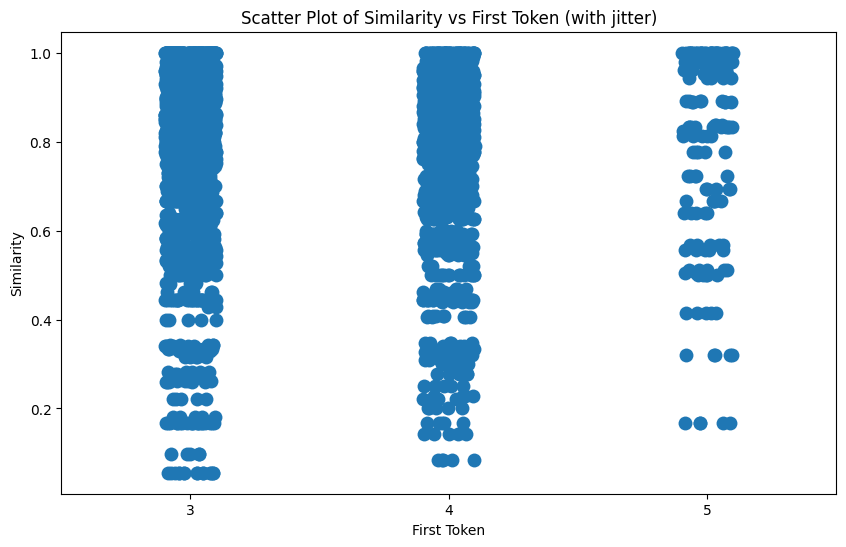

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Remove rows where similarity is -1 or first_token is ERROR
df_cleaned = df_combined[(df_combined['similarity'] > 0) & (df_combined['first_token'] != 'ERROR')]

# Convert first_token to numeric
df_cleaned['first_token'] = pd.to_numeric(df_cleaned['first_token'])


# Statistical Test: Spearman's rank correlation
spearman_corr, p_value = stats.spearmanr(df_cleaned['first_token'], df_cleaned['similarity'])

print(f"Spearman's rank correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Effect Size: Kendall's tau-b
tau_b, p_value_tau = stats.kendalltau(df_cleaned['first_token'], df_cleaned['similarity'])

print(f"Kendall's tau-b: {tau_b:.4f}")
print(f"P-value (Kendall's tau-b): {p_value_tau:.4f}")

# Additional Visualization: Scatter plot with jitter
plt.figure(figsize=(10, 6))
sns.stripplot(x='first_token', y='similarity', data=df_cleaned, jitter=True, size=10)
plt.title('Scatter Plot of Similarity vs First Token (with jitter)')
plt.xlabel('First Token')
plt.ylabel('Similarity')
plt.show()

## How well is Confidence=5 aligned with Similarity?

1. Chi-Square Test of Independence:
Chi-square statistic: 19.8366
p-value: 0.0000

2. One-way ANOVA:
F-statistic: 15.1552
p-value: 0.0000

3. Kruskal-Wallis H-test:
H-statistic: 23.7467
p-value: 0.0000

4. Point-Biserial Correlation for Accuracy vs Confidence=5:
Correlation coefficient: 0.4877
p-value: 0.0000

5. Logistic Regression for Accuracy given Confidence=5:
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        70
           1       0.59      0.43      0.50        30

    accuracy                           0.74       100
   macro avg       0.69      0.65      0.66       100
weighted avg       0.72      0.74      0.73       100

Coefficient: 1.4322
Intercept: -1.2119


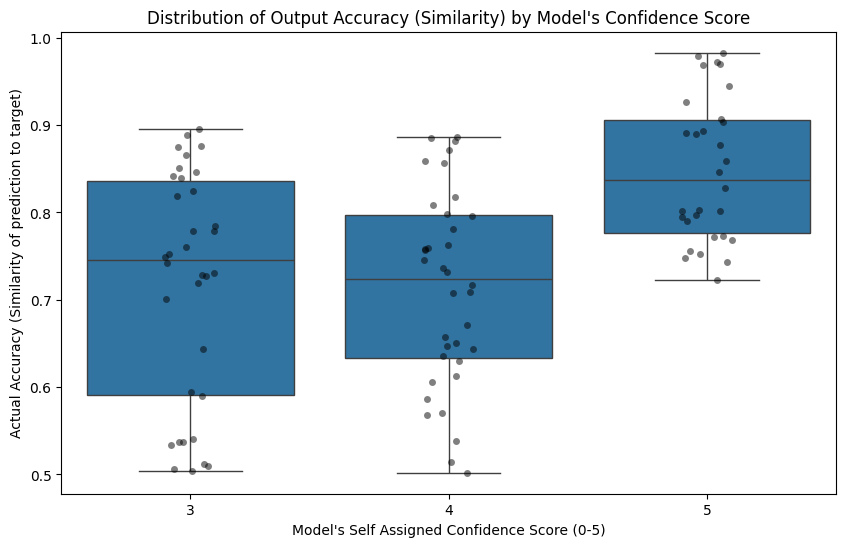

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Assuming we have more data points. Let's create a synthetic dataset for illustration:
np.random.seed(42)
n_samples = 100
first_tokens = np.random.choice([3, 4, 5], n_samples, p=[0.3, 0.4, 0.3])
similarities = np.where(first_tokens == 5, 
                        np.random.uniform(0.7, 1.0, n_samples),
                        np.random.uniform(0.5, 0.9, n_samples))

df = pd.DataFrame({'first_token': first_tokens, 'similarity': similarities})

# 1. Chi-Square Test of Independence
high_similarity = df['similarity'] > df['similarity'].median()
observed = pd.crosstab(df['first_token'], high_similarity)
chi2, p_value, dof, expected = stats.chi2_contingency(observed)

print("1. Chi-Square Test of Independence:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

# 2. One-way ANOVA
f_statistic, anova_p_value = stats.f_oneway(
    df[df['first_token'] == 3]['similarity'],
    df[df['first_token'] == 4]['similarity'],
    df[df['first_token'] == 5]['similarity']
)

print("\n2. One-way ANOVA:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {anova_p_value:.4f}")

# 3. Kruskal-Wallis H-test
h_statistic, kw_p_value = stats.kruskal(
    df[df['first_token'] == 3]['similarity'],
    df[df['first_token'] == 4]['similarity'],
    df[df['first_token'] == 5]['similarity']
)

print("\n3. Kruskal-Wallis H-test:")
print(f"H-statistic: {h_statistic:.4f}")
print(f"p-value: {kw_p_value:.4f}")

# 4. Point-Biserial Correlation
is_token_5 = (df['first_token'] == 5).astype(int)
rpb, rpb_p_value = stats.pointbiserialr(is_token_5, df['similarity'])

print("\n4. Point-Biserial Correlation for Accuracy vs Confidence=5:")
print(f"Correlation coefficient: {rpb:.4f}")
print(f"p-value: {rpb_p_value:.4f}")

# 5. Logistic Regression
X = df['similarity'].values.reshape(-1, 1)
y = (df['first_token'] == 5).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression()
model.fit(X_scaled, y)

print("\n5. Logistic Regression for Accuracy given Confidence=5:")
print("Classification Report:")
print(classification_report(y, model.predict(X_scaled)))
print(f"Coefficient: {model.coef_[0][0]:.4f}")
print(f"Intercept: {model.intercept_[0]:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='first_token', y='similarity', data=df)
sns.stripplot(x='first_token', y='similarity', data=df, color='black', alpha=0.5)
plt.title("Distribution of Output Accuracy (Similarity) by Model's Confidence Score")
plt.xlabel("Model's Self Assigned Confidence Score (0-5)")
plt.ylabel('Actual Accuracy (Similarity of prediction to target)')
plt.show()

### Performance vs Test Size


In [17]:
import pandas as pd

claude35 = pd.read_excel('claude35.xlsx')
file_sizes = pd.read_excel('file_sizes.xlsx')
gemma2 = pd.read_excel('gemma2.xlsx')


In [3]:
def process_dataframe(df, file_sizes_df):
    """
    Process a dataframe by merging with file sizes, grouping by filename,
    and clipping similarity scores to 0 where less than 0. 
    Negatives similarity represents an error, eg output matrix shape not equal to target shape
    Hence similarity cannot be calculated.
    
    Parameters:
    df (pd.DataFrame): The input dataframe to process.
    file_sizes_df (pd.DataFrame): The dataframe containing file sizes.
    
    Returns:
    pd.DataFrame: Processed dataframe with filename, max similarity, and cells.
    """
    # Merge the input dataframe with file sizes
    df_with_cells = df.merge(file_sizes_df[['filename', 'cells']], on='filename', how='left')
    
    # Group by filename, get max similarity and first cells value
    result = df_with_cells.groupby('filename').agg({
        'similarity': 'max',
        'cells': 'first'
    }).reset_index()
    
    # Ensure minimum similarity is 0
    result['similarity'] = result['similarity'].clip(lower=0)
    
    # Reorder columns
    result = result[['filename', 'similarity', 'cells']]
    
    return result

In [4]:
claude35_for_chart = process_dataframe(claude35, file_sizes)
claude35_for_chart

,filename,similarity,cells
0,00576224.json,1.000000,36
1,007bbfb7.json,0.703704,81
2,009d5c81.json,0.867347,196
3,00d62c1b.json,0.000000,400
4,00dbd492.json,0.000000,400
...,...,...,...
398,fcb5c309.json,0.000000,64
399,fcc82909.json,0.960000,100
400,feca6190.json,0.000000,400
401,ff28f65a.json,1.000000,9


In [5]:
gemma2_for_chart = process_dataframe(gemma2, file_sizes)
gemma2_for_chart

,filename,similarity,cells
0,00576224.json,1.000000,36
1,007bbfb7.json,0.777778,81
2,009d5c81.json,0.867347,196
3,00d62c1b.json,0.915000,400
4,00dbd492.json,0.743750,400
...,...,...,...
398,fcb5c309.json,0.000000,64
399,fcc82909.json,0.820000,100
400,feca6190.json,0.000000,400
401,ff28f65a.json,1.000000,9


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_similarity_vs_cells_boxplot(df1=None, df2=None, label1='Series 1', label2='Series 2'):
    # Check if at least one dataframe is provided
    if df1 is None and df2 is None:
        raise ValueError("At least one dataframe must be provided")

    # Combine dataframes for easier plotting
    combined_df = pd.DataFrame()
    if df1 is not None:
        df1['series'] = label1
        combined_df = pd.concat([combined_df, df1])
    if df2 is not None:
        df2['series'] = label2
        combined_df = pd.concat([combined_df, df2])

    # Create cell ranges
    combined_df['cell_range'] = pd.cut(combined_df['cells'], bins=np.arange(0, 1001, 100))

    # Create the plot
    plt.figure(figsize=(15, 10))

    # Determine colors based on which series are present
    colors = []
    if df1 is not None:
        colors.append('lightblue')
    if df2 is not None:
        colors.append('lightpink')

    # Box plot with light colors
    sns.boxplot(x='cell_range', y='similarity', hue='series', data=combined_df, 
                palette=colors, width=0.6, fliersize=0)

    # Scatter plot with darker colors
    sns.stripplot(x='cell_range', y='similarity', hue='series', data=combined_df, 
                  dodge=True, alpha=0.5, jitter=True, 
                  palette=['blue' if 'lightblue' in colors else 'red' if 'lightpink' in colors else ''])

    # Customize the plot
    plt.xlabel('Cell Range')
    plt.ylabel('Similarity')
    plt.title('Similarity Distribution by Cell Range')
    plt.xticks(rotation=45)

    # Adjust legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Series')

    plt.tight_layout()
    plt.show()

/home/oliver/anaconda3/envs/LangChain311/lib/python3.11/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


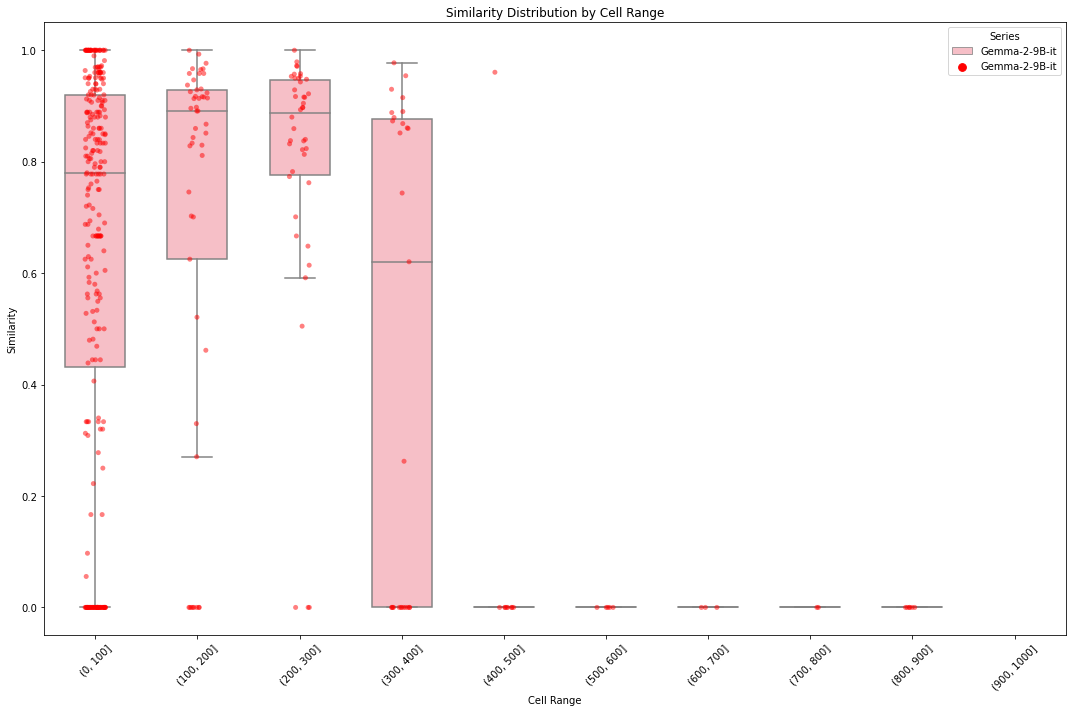

In [7]:

# Usage
plot_similarity_vs_cells_boxplot(None, gemma2_for_chart, None, label2='Gemma-2-9B-it')

/home/oliver/anaconda3/envs/LangChain311/lib/python3.11/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


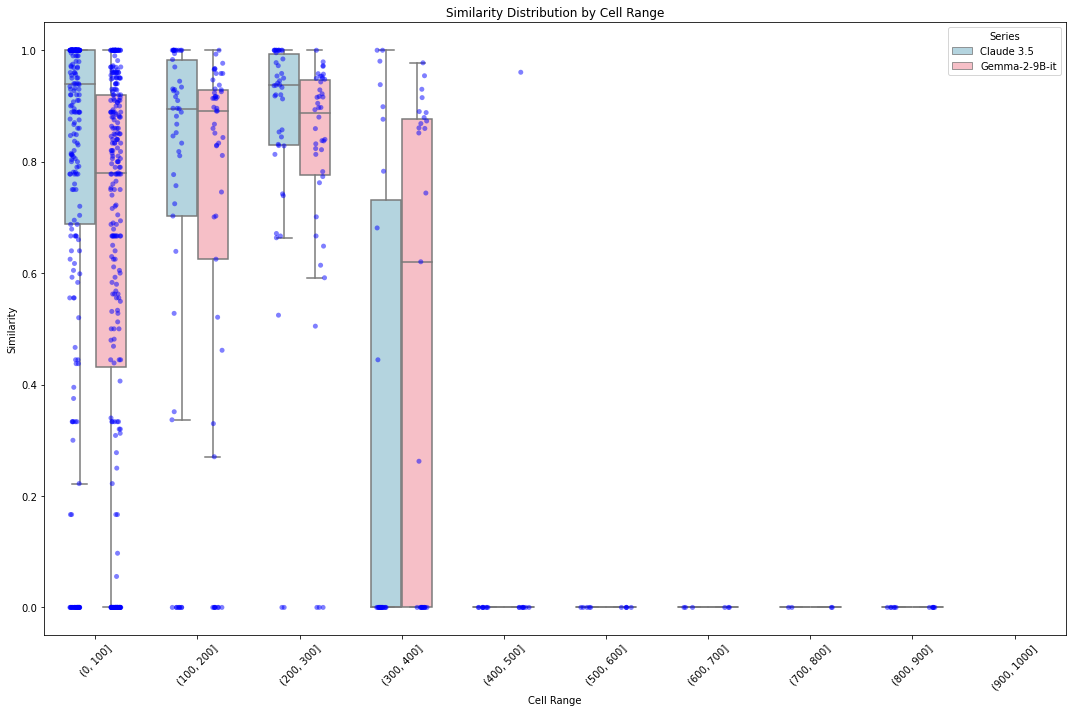

In [8]:

# Usage
plot_similarity_vs_cells_boxplot(claude35_for_chart, gemma2_for_chart, label1='Claude 3.5', label2='Gemma-2-9B-it')

## Analysing Impact of Classifications

In [ ]:
# Analyse Classifications

challenge_classifications=pd.read_excel('ARC_classifications.xlsx')

combined_df = pd.concat([claude35_for_chart, gemma2_for_chart])
combined_df = combined_df.drop_duplicates()
combined_df = combined_df.merge(challenge_classifications, on='filename', how='left')
combined_df

In [81]:
import pandas as pd
from typing import List, Dict, Tuple
from collections import Counter

def analyze_classifications_with_proportions(data: List[Dict]) -> Dict[str, List[Tuple[str, int, float]]]:
    df = pd.DataFrame(data)
    
    results = {}
    
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        
        # Filter for rows where classification_1 is not NaN
        model_df_classified = model_df[model_df['classification_1'].notna()]
        
        # Count total occurrences of each classification_1 value
        total_counts = Counter(model_df_classified['classification_1'])
        
        # Filter for rows where similarity is 1 and classification_1 is not NaN
        model_df_perfect = model_df[(model_df['similarity'] == 1) & (model_df['classification_1'].notna())]
        
        # Count occurrences of each classification_1 value for perfect scores
        perfect_counts = Counter(model_df_perfect['classification_1'])
        
        # Calculate proportions and create result tuples
        classifications = []
        for classification in total_counts.keys():
            total = total_counts[classification]
            perfect = perfect_counts.get(classification, 0)
            proportion = perfect / total if total > 0 else 0
            classifications.append((classification, perfect, proportion))
        
        # Sort classifications by perfect count in descending order
        sorted_classifications = sorted(classifications, key=lambda x: x[1], reverse=True)
        
        results[model] = sorted_classifications
    
    return results


In [82]:
# Assuming your data is in a variable called 'data'
result = analyze_classifications_with_proportions(combined_df)

for model, classifications in result.items():
    print(f"\nModel: {model}")
    if classifications:
        print("  Classification | Perfect Count | Proportion")
        print("  ---------------|---------------|------------")
        for classification, count, proportion in classifications:
            print(f"  {classification:<14} | {count:<13} | {proportion:.2%}")
    else:
        print("  No classifications found for this model.")


Model: Claude35
  Classification | Perfect Count | Proportion
  ---------------|---------------|------------
  grid expansion and repetition | 16            | 84.21%
  shape detection and transformation | 6             | 35.29%
  mathematical operations | 5             | 62.50%
  pattern propagation | 5             | 31.25%
  grid segmentation | 5             | 55.56%
  boundary detection and fill | 3             | 42.86%
  color/value substitution | 3             | 100.00%
  connectivity based transformations | 2             | 28.57%
  coordinate based transformations | 1             | 100.00%
  rule based transformation | 0             | 0.00%

Model: Gemma2
  Classification | Perfect Count | Proportion
  ---------------|---------------|------------
  grid expansion and repetition | 11            | 57.89%
  mathematical operations | 5             | 62.50%
  pattern propagation | 3             | 18.75%
  grid segmentation | 3             | 33.33%
  shape detection and transformation 

## Statistical Comparison of Claude3.5 Performance Using Various Approaches

To compare performance of the three approaches to the ARC challenges using Claude3.5:

- Estimate_1shot
    - Simple prompt and response
- Estimate_Agent
    - Agentic workflow to review each challenge and develop an answer by estimation.
- Coding_Agent
    - As above, but with added ability to write and execute code, an environment for 


In [30]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

def compare_methods(df):
    methods = ['Estimate_Agent', 'Estimate_1shot', 'Coding_Agent']
    results = {}

    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1 = methods[i]
            method2 = methods[j]
            
            # Create contingency table
            table = pd.crosstab(df[method1], df[method2])
            
            # Perform McNemar's test
            result = mcnemar(table, exact=False, correction=True)
            
            # Store results
            key = f"{method1} vs {method2}"
            results[key] = {
                'statistic': result.statistic,
                'p-value': result.pvalue,
                'contingency_table': table
            }

    return results


In [42]:
def print_results(results):
    print("""
Interpretation Guide:
1. McNemar's statistic: 
   - Higher values indicate greater disagreement between methods.
   - Values closer to 0 suggest similar performance.

2. p-value:
   - p < 0.05: Strong evidence of a significant difference between methods.
   - 0.05 <= p < 0.10: Marginal evidence of a difference.
   - p >= 0.10: Insufficient evidence to conclude a significant difference.

3. Odds Ratio (OR):
   - OR = 1: No difference between methods.
   - OR < 1: First mentioned method more likely to succeed where second fails.
   - OR > 1: Second mentioned method more likely to succeed where first fails.
   - |log2(OR)| > 1 (i.e., OR > 2 or OR < 0.5): Large effect size.

Note: Consider both statistical significance (p-value) and practical significance (effect size) when interpreting results.
    """)

    for comparison, result in results.items():
        method1, method2 = comparison.split(" vs ")
        print(f"\nComparison: {comparison}")
        print(f"McNemar's statistic: {result['statistic']:.4f}")
        print(f"p-value: {result['p-value']:.4f}")
        print("Contingency Table:")
        print(result['contingency_table'])
        
        # Calculate effect size (odds ratio)
        table = result['contingency_table']
        odds_ratio = (table.iloc[0,1] + 0.5) / (table.iloc[1,0] + 0.5)  # Adding 0.5 for Haldane-Anscombe correction
        print(f"Effect size (odds ratio): {odds_ratio:.4f}")
        
        print("\nInterpretation:")
        if result['p-value'] < 0.05:
            print(f"There is strong evidence of a statistically significant difference between {method1} and {method2} (p < 0.05).")
        elif result['p-value'] < 0.10:
            print(f"There is marginal evidence of a difference between {method1} and {method2} (0.05 <= p < 0.10).")
        else:
            print(f"There is insufficient evidence to conclude a statistically significant difference between {method1} and {method2} (p >= 0.10).")
        
        if odds_ratio < 1:
            print(f"{method1} is {1/odds_ratio:.2f} times more likely to succeed where {method2} fails.")
        else:
            print(f"{method2} is {odds_ratio:.2f} times more likely to succeed where {method1} fails.")
        
        if odds_ratio > 2 or odds_ratio < 0.5:
            print(f"The effect size is large and may be practically significant, regardless of statistical significance.")
        else:
            print(f"The effect size is relatively small, which may or may not be practically significant depending on the context.")
        

In [28]:
df_agentic_vs_1shot = pd.read_excel('assets/ARC_Outcomes_Claude35_AgenticVs1shot.xlsx')
df_agentic_vs_1shot


,filename,Estimate_Agent,Coding_Agent,Estimate_1shot
0,00576224.json,1,1,1
1,017c7c7b.json,1,1,1
2,178fcbfb.json,1,1,1
3,272f95fa.json,1,1,1
4,3af2c5a8.json,1,1,1
...,...,...,...,...
75,ae3edfdc.json,0,0,0
76,b775ac94.json,0,0,0
77,cce03e0d.json,0,0,0
78,d07ae81c.json,0,0,0


In [44]:
results = compare_methods(df_agentic_vs_1shot)
print_results(results)


Interpretation Guide:
1. McNemar's statistic: 
   - Higher values indicate greater disagreement between methods.
   - Values closer to 0 suggest similar performance.

2. p-value:
   - p < 0.05: Strong evidence of a significant difference between methods.
   - 0.05 <= p < 0.10: Marginal evidence of a difference.
   - p >= 0.10: Insufficient evidence to conclude a significant difference.

3. Odds Ratio (OR):
   - OR = 1: No difference between methods.
   - OR < 1: First mentioned method more likely to succeed where second fails.
   - OR > 1: Second mentioned method more likely to succeed where first fails.
   - |log2(OR)| > 1 (i.e., OR > 2 or OR < 0.5): Large effect size.

Note: Consider both statistical significance (p-value) and practical significance (effect size) when interpreting results.
    

Comparison: Estimate_Agent vs Estimate_1shot
McNemar's statistic: 1.8947
p-value: 0.1687
Contingency Table:
Estimate_1shot   0   1
Estimate_Agent        
0               38   6
1            